In [8]:
from google.colab import drive
import pandas as pd
import os # Import the os module

# 2. Baca file (Sesuaikan jalur foldernya)
# Misal file kamu ada di folder 'Tugas_Sentimen'
path = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen /train.csv'
df_raw = pd.read_csv(path, encoding='latin-1') # Pakai latin-1 jika utf-8 error

# 3. Proses Dataset sesuai instruksi tugas
# Sesuaikan nama kolom (di gambar kamu kolomnya bernama 'text' dan 'sentiment')
pos = df_raw[df_raw['sentiment'] == 'positive'].head(100)
neg = df_raw[df_raw['sentiment'] == 'negative'].head(100)
neu = df_raw[df_raw['sentiment'] == 'neutral'].head(100)

# Gabungkan jadi data pelatihan (300 kalimat)
df_train = pd.concat([pos, neg, neu]).sample(frac=1).reset_index(drop=True)

# Ambil 400 data untuk pengujian (Hapus kolom label/sentiment)
# Kita ambil dari baris sisanya
df_test = df_raw.drop(df_train.index).head(400)
df_test = df_test[['text']] # Hanya ambil teks saja tanpa label

# 4. Simpan hasilnya kembali ke Drive agar aman
# Define the directory path
save_dir = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen'
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

df_train.to_csv(os.path.join(save_dir, 'train_final.csv'), index=False)
df_test.to_csv(os.path.join(save_dir, 'test_final.csv'), index=False)

print("Data berhasil disiapkan di Google Drive!")

Data berhasil disiapkan di Google Drive!


In [9]:
!pip install transformers[torch] datasets


In [15]:
import pandas as pd
import torch
from google.colab import drive
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# 1. Mount Drive & Load Data
path_train = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen/train_final.csv'
path_test = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen/test_final.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

# 2. Ubah label teks ke angka agar dimengerti model
# Positif: 2, Netral: 1, Negatif: 0
label_map = {"positive": 2, "neutral": 1, "negative": 0}
df_train['label'] = df_train['sentiment'].map(label_map)

# 3. Load Tokenizer (Mengubah teks jadi angka)
model_name = "bert-base-uncased" # Kamu bisa ganti ke "indobenchmark/indobert-base-p1" jika teks Indo
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Konversi ke format Dataset Hugging Face
train_ds = Dataset.from_pandas(df_train[['text', 'label']])
train_ds = train_ds.map(tokenize_function, batched=True)

# 4. Setup Model BERT
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 5. Training Arguments (Pengaturan Pelatihan)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3, # Melatih 3 kali putaran
    per_device_train_batch_size=8,
    logging_dir="./logs",
)

# 6. Mulai Pelatihan (Fine-Tuning)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
)

print("Sedang melatih model... tunggu sebentar.")
trainer.train()

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sedang melatih model... tunggu sebentar.


Step,Training Loss


TrainOutput(global_step=114, training_loss=0.894861522473787, metrics={'train_runtime': 94.5912, 'train_samples_per_second': 9.515, 'train_steps_per_second': 1.205, 'total_flos': 236802075955200.0, 'train_loss': 0.894861522473787, 'epoch': 3.0})

In [18]:
import numpy as np
import pandas as pd

# Jalur file (Pastikan nama file benar sesuai yang ada di Drive kamu)
output_path = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen/test_labeled_result.csv'
path_test = '/content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen/test_final.csv'

# Cek apakah df_test sudah ada, jika belum, baca dari Drive
try:
    if 'df_test' not in locals():
        df_test = pd.read_csv(path_test)

    # Fungsi untuk prediksi
    def predict_sentiment(text):
        # Pastikan teks tidak kosong/null
        if pd.isna(text): return 1 # Default ke netral jika kosong
        inputs = tokenizer(str(text), return_tensors="pt", padding=True, truncation=True).to("cuda")
        model.to("cuda")
        outputs = model(**inputs)
        probs = outputs[0].softmax(1)
        return np.argmax(probs.detach().cpu().numpy())

    # Balikkan angka ke teks label
    reverse_label_map = {2: "positive", 1: "neutral", 0: "negative"}

    print("Sedang menebak 400 data pengujian... Harap tunggu.")

    # Melakukan prediksi
    df_test['sentiment_prediction'] = df_test['text'].apply(lambda x: reverse_label_map[predict_sentiment(x)])

    # Simpan hasil akhir ke Drive
    df_test.to_csv(output_path, index=False)

    print(f"Selesai! Hasil prediksi disimpan di: {output_path}")
    print(df_test.head())

except FileNotFoundError:
    print("Error: File 'test_final.csv' tidak ditemukan di Drive. Cek kembali folder kamu.")
except Exception as e:
    print(f"Terjadi kesalahan: {e}")

Sedang menebak 400 data pengujian... Harap tunggu.
Selesai! Hasil prediksi disimpan di: /content/drive/MyDrive/deep learning lanjut/Tugas_Sentimen/test_labeled_result.csv
                                                text sentiment_prediction
0          tonight in party w/ my girls (minus vita)             positive
1    why not now you made me sad I thought you`d ...             negative
2                                      Simple my a#@              neutral
3  The pics I just uploaded are the baby pics of ...             positive
4          I saw the play of it here, it was amazing             positive


/tmp/ipython-input-2548792954.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


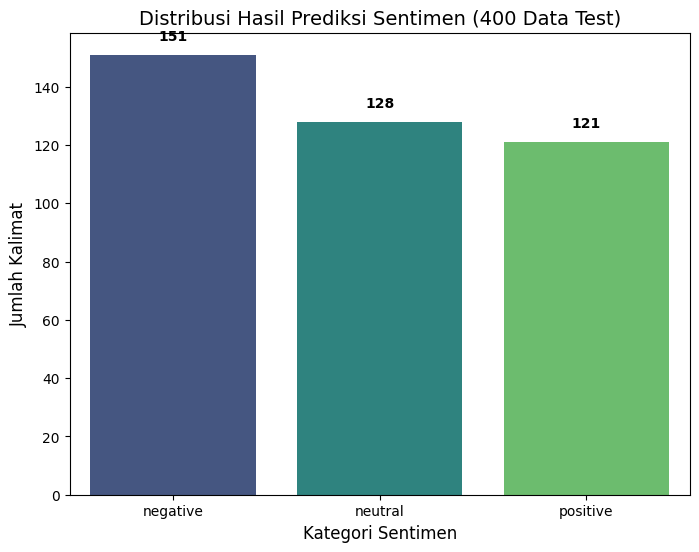

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hitung jumlah tiap sentimen dari hasil tebakan
counts = df_test['sentiment_prediction'].value_counts()

# 2. Buat visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 3. Tambah judul dan keterangan
plt.title('Distribusi Hasil Prediksi Sentimen (400 Data Test)', fontsize=14)
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah Kalimat', fontsize=12)

# Tampilkan angka di atas batang
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
